# Waddinton OT trajectory analysis


In [3]:
import scrabbit
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import Box,fixed,interact,interactive,HBox,Layout
import scanpy as sc
import pandas as pd
import wot
import scipy
import anndata

## Load trajectories

In [ ]:
r_data = sc.read_h5ad("../data-in/rabbit/anndata.h5ad")
r_data

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 146133 × 30725
    obs: 'cell', 'barcode', 'sample', 'stage', 'batch', 'doub.density', 'doublet', 'stripped', 'cluster', 'sizeFactor', 'celltype', 'singler', 'leiden_res1', 'leiden_res8', 'anatomical_loc', 'day'
    var: 'ensembl_ids'
    uns: 'anatomical_loc_colors', 'celltype_colors', 'leiden', 'neighbors', 'singler_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

In [59]:
def loadWOTCSV(wot_path):
    adata = anndata.read_csv(wot_path + "X.csv",delimiter="\t")
    adata.obs = pd.read_csv(wot_path + "obs.csv", sep="\t",index_col=0)
    adata.var = pd.read_csv(wot_path + "var.csv", sep="\t",index_col=0)
    return(adata)
    

In [46]:
r_traj = loadWOTCSV("../data-test/rabbit/trajectory_analysis/trajectory/")

In [60]:
r_fates = loadWOTCSV("../data-test/rabbit/trajectory_analysis/fates/")

In [62]:
r_traj.obsm["X_umap"] = r_data.obsm["X_umap"]
r_fates.obsm["X_umap"] = r_data.obsm["X_umap"]

### Visualise trajectories


In [65]:
rabbit_dropdown = widgets.Dropdown(
    options=r_traj.var.index,
    description='Trajectory:'
)

def plotWOTTrajectory(adata, celltype):
    sc.pl.umap(adata,color=celltype,color_map="viridis_r")

traj_widget = interactive(plotWOTTrajectory, adata=fixed(r_traj), celltype=rabbit_dropdown)
fate_widget = interactive(plotWOTTrajectory, adata=fixed(r_fates), celltype=rabbit_dropdown)

items = [traj_widget,fate_widget]
HBox(items,layout=Layout(flex_flow="flex-inline"))

In [42]:
rabbit_dropdown = widgets.Dropdown(
    options=rabbit_trajectory.var.index,
    description='Trajectory:'
)

rabbit_day_dropdown = widgets.Dropdown(
    options=[7,8,9,"All"],
    description='Stage:',
    value="All"
)


mouse_dropdown = widgets.Dropdown(
    options=mouse_trajectory.var.index,
    description='Trajectory:'
)

mouse_day_dropdown = widgets.Dropdown(
    options=[6.5,6.75,7,7.25,7.5,7.75,8,8.25,8.5,"All"],
    description='Stage:',
    value="All"
)



def update_trajectory_vis(name,trajectory,coord_df,day):
    figure = plt.figure(figsize=(7, 7))
    plt.axis('off')
    plt.tight_layout()
    #plt.title(name)
    
    if(day!="All"):
        coord_df = coord_df[trajectory.obs["day"]==day]
        binned_df = trajectory.obs[trajectory.obs["day"]==day].copy()
        binned_df['values'] = trajectory[trajectory.obs["day"]==day, name].X
    else:
        binned_df = trajectory.obs.copy()
        binned_df['values'] = trajectory[:, name].X


    plt.scatter(coord_df['umap1'], coord_df['umap2'], c='#f0f0f0',
                       s=4, marker=',', edgecolors='none', alpha=0.8)
    binned_df = binned_df.groupby(['umap1', 'umap2'], as_index=False).sum()
    plt.scatter(binned_df['umap1'], binned_df['umap2'], c=binned_df['values'],
                   s=6, marker=',', edgecolors='none', vmax=binned_df['values'].quantile(0.975))
    plt.colorbar().ax.set_title('Trajectory')


rabbit_widget = interactive(update_trajectory_vis, name=rabbit_dropdown,trajectory=fixed(rabbit_trajectory),
                          coord_df=fixed(rabbit_coords),day=rabbit_day_dropdown)
mouse_widget =  interactive(update_trajectory_vis, name=mouse_dropdown,trajectory=fixed(mouse_trajectory),
                          coord_df=fixed(mouse_coords),day=mouse_day_dropdown)


items = [rabbit_widget,mouse_widget]
HBox(items,layout=Layout(flex_flow="flex-inline"))


In [437]:
# Extract cells of trajectory
rabbit_neural_cells = pd.DataFrame(rabbit_trajectory.obs[rabbit_trajectory.X[:,15] > 0.0002].index)
rabbit_neural_cells.to_csv("data/rabbit/neural_fated_cells.tsv",sep="\t",index=False,header=False)


In [443]:
mouse_neural_cells = pd.DataFrame(mouse_trajectory.obs[mouse_trajectory.X[:,3] > 0.001].index)
mouse_neural_cells.to_csv("data/mouse/neural_fated_cells.tsv",sep="\t",index=False,header=False)

In [ ]:
rabbit_wot_summary = wot.ot.compute_validation_summary(rabbit_ot_model)

In [18]:
#Compute trends for all genes
rabbit_trends = wot.tmap.trajectory_trends_from_trajectory(rabbit_trajectory, rabbit_raw)

# Need to change cell type names which include forward slash /
slash_dict = {"Forebrain/Midbrain/Hindbrain":"Forebrain_Midbrain_Hindbrain","Notochord/Floor plate":"Notochord_Floor_plate"}
rabbit_trajectory.var.rename(slash_dict,inplace=True)

# Save each trajectory in a separate file
for i in range(len(rabbit_trends)):
    wot.io.write_dataset(rabbit_trends[i], "tmaps/rabbit/corrected/trends/" + rabbit_trajectory.var.index[i] + '_trends.txt')

In [257]:
#Compute trends for all genes
mouse_trends = wot.tmap.trajectory_trends_from_trajectory(mouse_trajectory, mouse_raw)

# Need to change cell type names which include forward slash /
slash_dict = {"Forebrain/Midbrain/Hindbrain":"Forebrain_Midbrain_Hindbrain"}
mouse_trajectory.var.rename(slash_dict,inplace=True)

# Save each trajectory in a separate file
for i in range(len(mouse_trends)):
    wot.io.write_dataset(mouse_trends[i], "tmaps/mouse/corrected/trends/" + mouse_trajectory.var.index[i] + '_trends.txt')

/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [254]:
# If need to load trend data...

trajectory_trend_datasets = []
trajectory_names = []

for i in range(rabbit_trajectory.shape[1]):
    trajectory_names.append(rabbit_trajectory.var.index[i])
    trajectory_trend_datasets.append(wot.io.read_dataset("tmaps/rabbit/corrected/trends/" + rabbit_trajectory.var.index[i] + '_trends.txt'))

In [584]:
rabbit_dropdown = widgets.SelectMultiple(
    options=rabbit_trajectory.var.index,
    value=[rabbit_trajectory.var.index[0]],
    description='Trajectory:'
)

mouse_dropdown = widgets.SelectMultiple(
    options=mouse_trajectory.var.index,
    value=[mouse_trajectory.var.index[0]],
    description='Trajectory:'
)


rabbit_gene_input = widgets.Text(
    placeholder='',
    description='Genes:',
    value='ENSOCUG00000025597',
    continuous_update=False
)

mouse_gene_input = widgets.Text(
    placeholder='',
    description='Genes:',
    value='ENSMUSG00000031162',
    continuous_update=False
)

def update_trends_vis(selected_trajectories, gene_names,trajectory_trend_datasets,trajectory_names):
    gene_names = gene_names.replace(' ', '').split(',')
    
    figure = plt.figure(figsize=(10, 10))
    
    
    for selected_trajectory in selected_trajectories:
        trajectory_index = trajectory_names.index(selected_trajectory)
        mean = trajectory_trend_datasets[trajectory_index]
        mean = mean[:, mean.var.index.str.lower().isin([gene.lower() for gene in gene_names])]
        timepoints = mean.obs.index.values.astype(float)
        mean.obs.index = mean.obs.index.astype('category')
    
        if mean.shape[1] > 0:
            for i in range(mean.shape[1]):  # each gene
                mean_i = mean[:, i].X
                plt.plot(timepoints, mean_i, label=mean.var.index[i] + ', ' + selected_trajectory)
            plt.xlabel("Day")
            plt.ylabel("Expression")
            plt.legend()

rabbit_widget = interactive(update_trends_vis, selected_trajectories=rabbit_dropdown, gene_names=rabbit_gene_input,
                           trajectory_trend_datasets = fixed(rabbit_trends), trajectory_names = fixed(rabbit_trajectory.var.index.tolist()))
mouse_widget = interactive(update_trends_vis, selected_trajectories=mouse_dropdown, gene_names=mouse_gene_input,
                          trajectory_trend_datasets = fixed(mouse_trends), trajectory_names = fixed(mouse_trajectory.var.index.tolist()))


items = [rabbit_widget,mouse_widget]
HBox(items,layout=Layout(flex_flow="flex-inline"))

## Calculate cell fates

In [100]:
rabbit_fates = rabbit_tmap_model.fates(rabbit_populations)
mouse_fates = mouse_tmap_model.fates(mouse_populations)


In [351]:
rabbit_fates.write_h5ad("data/rabbit/wot_fates.h5ad")

In [369]:
len(rabbit_populations[0].p)


33369

In [352]:
mouse_fates.write_h5ad("data/mouse/wot_fates.h5ad")

In [357]:
rabbit_fates.write_csvs("data/rabbit/out/fates/",skip_data=False,sep="\t")
mouse_fates.write_csvs("data/mouse/out/fates/",skip_data=False,sep="\t")


writing .csv files to data/rabbit/out/fates
writing .csv files to data/mouse/out/fates


In [184]:
scipy.io.mmwrite("data/rabbit/fate_matrix.mtx",rabbit_fates.X,field="real",precision=8)

In [183]:
scipy.io.mmwrite("data/mouse/fate_matrix.mtx",mouse_fates.X,field="real")

In [411]:
rabbit_fates.obs.to_csv("data/rabbit/fates_matrix_obs.tsv",sep="\t")

In [412]:
mouse_fates.obs.to_csv("data/mouse/fates_matrix_obs.tsv",sep="\t")

In [103]:
import math
fate_dropdown1 = widgets.Dropdown(
    options=fate_ds.var.index,
    description='Fate 1:'
)
fate_dropdown2 = widgets.Dropdown(
    options=fate_ds.var.index,
    description='Fate 2:',
    value=fate_ds.var.index[1]
)
day_dropdown = widgets.Dropdown(
    options=fate_ds.obs['day'].unique(),
    description='Day',
    value=7
)


def update_fate_vis(name1, name2,day):
    figure = plt.figure(figsize=(10, 10))   

    fate1 = fate_ds[:,name1][fate_ds.obs['day']==day].X.flatten()
    fate2 = fate_ds[:,name2][fate_ds.obs['day']==day].X.flatten()

    Nrows = len(fate1)
    x = np.zeros(Nrows)
    y = np.zeros(Nrows)
    P = np.array([[1,0],[np.cos(2*math.pi/3),math.sin(2*math.pi/3)],[math.cos(4*math.pi/3),math.sin(4*math.pi/3)]])

    for i in range(0,Nrows):
        ff = np.array([fate1[i],fate2[i],1-(fate1[i]+fate2[i])])
        x[i] = (ff @ P)[0]
        y[i] = (ff @ P)[1]

    vx = P[:,0]
    vy = P[:,1]
    t1 = plt.Polygon(P, color=(0,0,0,0.1))
    plt.gca().add_patch(t1)
    
    plt.scatter(x,y)
    plt.scatter(vx,vy)
    #plt.scatter(0,0)
    plt.text(P[0,0]+.1, P[0,1], name1)
    plt.text(P[1,0]-.1, P[1,1]+.1, name2)
    plt.text(P[2,0]-.1, P[2,1]-.2, 'Other')
    plt.axis('equal')
    plt.axis('off')
    #plt.xticks([])
    #plt.yticks([])
    
    plt.title('{} vs. {} on day {}'.format(name1, name2,day))

widgets.interact(update_fate_vis, name1=fate_dropdown1, name2=fate_dropdown2,day=day_dropdown)

interactive(children=(Dropdown(description='Fate 1:', options=('ExE mesoderm', 'Rostral neurectoderm', 'Erythr…

<function __main__.update_fate_vis(name1, name2, day)>

In [105]:
mouse_coords = compute_coord_df(mouse_umap)
rabbit_coords = compute_coord_df(rabbit_umap)

### Visualise cell fates

In [106]:
rabbit_celltype_dropdown = widgets.Dropdown(
    options=rabbit_fates.var.index,
    description='Fate:'
)

mouse_celltype_dropdown = widgets.Dropdown(
    options=mouse_fates.var.index,
    description='Fate:'
)

mouse_day_dropdown = widgets.Dropdown(
    options=[6.5,6.75,7,7.25,7.5,7.75,8,8.25,8.5],
    description='Stage:'
)


rabbit_day_dropdown = widgets.Dropdown(
    options=[7,8,9],
    description='Stage:'
)


def update_fate_vis(fate_ds,coord_df, name1, day):
    figure = plt.figure(figsize=(10, 10))   

    coord_df = coord_df[fate_ds.obs["day"]==day]

    fate1 = fate_ds[:,name1][fate_ds.obs['day']==day].X.flatten()
    #fate2 = fate_ds[:,name2][fate_ds.obs['day']==day].X.flatten()

    #binned_df = rabbit_trajectory.obs.copy()
    #binned_df['values'] = fate1
    coord_df["values"] = 0
    coord_df["values"][fate_ds[:,name1][fate_ds.obs['day']==day].obs.index] = fate1

    
    plt.scatter(coord_df['umap1'], coord_df['umap2'], c='#f0f0f0',
                       s=4, marker=',', edgecolors='none', alpha=0.8)
    #binned_df = binned_df.groupby(['umap1', 'umap2'], as_index=False).sum()
    plt.scatter(coord_df['umap1'], coord_df['umap2'], c=coord_df["values"],
                   s=6, marker=',', edgecolors='none', vmax=coord_df['values'].quantile(0.975))
    plt.colorbar().ax.set_title('Trajectory')

    #plt.title('{} vs. {} on day {}'.format(name1,day))


rabbit_widget = interactive(update_fate_vis, fate_ds=fixed(rabbit_fates),coord_df=fixed(rabbit_coords), name1=rabbit_celltype_dropdown, day=rabbit_day_dropdown)
mouse_widget = interactive(update_fate_vis, fate_ds=fixed(mouse_fates), coord_df=fixed(mouse_coords),name1=mouse_celltype_dropdown, day=mouse_day_dropdown)



items = [rabbit_widget,mouse_widget]
HBox(items,layout=Layout(flex_flow="flex-inline"))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [365]:
fate_ds[:,"PGC"][fate_ds.obs['day']==8].obs.index

/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Index(['cell_27914', 'cell_48773', 'cell_29184', 'cell_49918', 'cell_22331',
       'cell_28084', 'cell_54881', 'cell_31388', 'cell_52603', 'cell_46189',
       ...
       'cell_55869', 'cell_44158', 'cell_58178', 'cell_25203', 'cell_56143',
       'cell_43322', 'cell_47179', 'cell_23867', 'cell_44946', 'cell_57348'],
      dtype='object', length=11945)

In [92]:
fate_dropdown1 = widgets.Dropdown(
    options=fate_ds.var.index,
    description='Fate 1:'
)
fate_dropdown2 = widgets.Dropdown(
    options=fate_ds.var.index,
    description='Fate 2:',
    value=fate_ds.var.index[1]
)

def update_fate_vis(name1, name2):
    figure = plt.figure(figsize=(10, 10))
    fate1 = fate_ds[:, name1].X
    fate2 = fate_ds[:, name2].X
    p = np.log(1e-9 + np.divide(fate1, fate2, out=np.zeros_like(fate1), where=fate2 != 0))
    plt.scatter(fate_ds.obs['day'], p, s=4, marker=',')
    plt.xlabel('Day')
    plt.ylabel('Log Odds')
    plt.title('{} vs. {}'.format(name1, name2))

widgets.interact(update_fate_vis, name1=fate_dropdown1, name2=fate_dropdown2)

interactive(children=(Dropdown(description='Fate 1:', options=('ExE mesoderm', 'Rostral neurectoderm', 'Erythr…

<function __main__.update_fate_vis(name1, name2)>

In [91]:
fate_ds = mouse_fates

## Compute differentially expressed genes

Load shared features (one-to-one orthologs)...

In [43]:
sfs = pd.read_csv(data_path + "sfs.csv",header=0,index_col=0,sep=" ")
sfs.head(10)


,rabbit,mouse
ENSOCUG00000000006,ENSOCUG00000000006,Inpp1
ENSOCUG00000000007,ENSOCUG00000000007,Glipr2
ENSOCUG00000000008,ENSOCUG00000000008,Ccin
ENSOCUG00000000009,ENSOCUG00000000009,Clta
ENSOCUG00000000010,ENSOCUG00000000010,Gne
ENSOCUG00000000025,ENSOCUG00000000025,Slco2a1
ENSOCUG00000000031,ENSOCUG00000000031,Pbk
ENSOCUG00000000032,ENSOCUG00000000032,Nuggc
ENSOCUG00000000034,ENSOCUG00000000034,Elp3
ENSOCUG00000000044,ENSOCUG00000000044,4930550C14Rik


In [24]:
# Compute DEGs predictive of a given cell fate at a given timepoint
def getFatePredictiveGenes(adata, tmap_model, cellset, celltype, at_time=9,timepoint=7,compare='within'):
    target_cell_set = tmap_model.population_from_cell_sets({celltype:cellset[celltype]}, at_time=at_time)
    fates = tmap_model.fates(target_cell_set)
    results = wot.tmap.diff_exp(adata[adata.obs['day'].isin([timepoint])], fates, compare=compare)
    #results = diff_exp[(diff_exp['t_fdr']<0.01)&(diff_exp['name1']==celltype)].sort_values('fold_change', ascending=False)
    return(results)

# Find differentially expressed genes across both species
def findDEGsInCommon(rabbit_adata, rabbit_genes, mouse_adata, mouse_genes, sfs):
    mouse_dge_sfs = sfs[sfs["mouse"].isin(mouse_adata.var.loc[mouse_genes]["gene_names"])]
    rabbit_dge_sfs = sfs[sfs["rabbit"].isin(rabbit_genes)]
    out = pd.merge(rabbit_dge_sfs,mouse_dge_sfs, how='inner')
    return(out)

def findUniqueDEGs(rabbit_adata, rabbit_genes, mouse_adata, mouse_genes, sfs):
    mouse_dge_sfs = sfs[sfs["mouse"].isin(mouse_adata.var.loc[mouse_genes]["gene_names"])]
    rabbit_dge_sfs = sfs[sfs["rabbit"].isin(rabbit_genes)]
    out = set(mouse_dge_sfs["mouse"]).symmetric_difference(rabbit_dge_sfs["mouse"])
    return(out)

In [ ]:
#Epiblast - Nascent mesoderm
epi_meso = getFatePredictiveGenes(rabbit_raw,rabbit_tmap_model,rabbit_gmt,"Nascent mesoderm",7,7)


In [35]:
target_cell_set = rabbit_tmap_model.population_from_cell_sets({"Allantoic mesoderm":rabbit_gmt["Allantoic mesoderm"]}, at_time=9)
fates = rabbit_tmap_model.fates(target_cell_set)

In [36]:
#gd7_results = wot.tmap.diff_exp(rabbit_raw[rabbit_raw.obs['day'].isin([7])], fates, compare='all')
gd8_results = wot.tmap.diff_exp(rabbit_raw[rabbit_raw.obs['day'].isin([8])], fates, compare='all')
gd9_results = wot.tmap.diff_exp(rabbit_raw[rabbit_raw.obs['day'].isin([9])], fates, compare='all')


/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/nfs/research1/marioni/dkeitley/a

In [25]:
gd7 = getFatePredictiveGenes(rabbit_raw,rabbit_tmap_model,rabbit_gmt,"Allantoic mesoderm",9,7,"all")

/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [38]:
gd9_results.to_csv("/nfs/research1/marioni/dkeitley/rabbit-gastrulation-atlas/trajectory_analysis/rabbit/allantois/gd9_degs.csv")

In [ ]:
gd7[(gd7['fold_change']>=2)].sort_values('t_score', ascending=False).iloc[1:10,:]

In [22]:
results[(results['name1']=='Allantoic mesoderm') & (results['day1']==) & (results['fold_change']>=2) & (results['t_fdr']<=0.01)].sort_values('t_score', ascending=False)


,fold_change,mean1,mean2,fraction_expressed1,fraction_expressed2,t_score,t_pval,t_fdr,fraction_expressed_ratio,day1,day2,name1,name2
index,,,,,,,,,,,,,
ENSOCUG00000009399,29.916855,3.780214,0.381792,0.920358,0.348124,311.600983,0.0,0.0,2.643293,8.0,7.0,Allantoic mesoderm,Allantoic mesoderm
LGALS1,14.121402,2.991799,0.344107,0.894863,0.423906,301.971313,0.0,0.0,2.110731,8.0,7.0,Allantoic mesoderm,Allantoic mesoderm
SLC2A1,14.501768,4.206435,1.532165,0.982134,0.925775,299.725922,0.0,0.0,1.060872,8.0,7.0,Allantoic mesoderm,Allantoic mesoderm
ENSOCUG00000008728,6.665721,1.931020,0.034042,0.794130,0.060097,291.736847,0.0,0.0,13.193889,8.0,7.0,Allantoic mesoderm,Allantoic mesoderm
VIM,30.847126,4.416371,0.987328,0.946444,0.587250,277.299805,0.0,0.0,1.611551,8.0,7.0,Allantoic mesoderm,Allantoic mesoderm
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATP8,2.058486,1.689093,0.967122,0.786733,0.765725,83.739006,0.0,0.0,1.027431,8.0,7.0,Allantoic mesoderm,Allantoic mesoderm
APOA1,2.427228,1.629652,0.742902,0.704353,0.647727,79.766777,0.0,0.0,1.087409,8.0,7.0,Allantoic mesoderm,Allantoic mesoderm
TAGLN2,2.360009,2.177438,1.318773,0.855839,0.791033,77.451111,0.0,0.0,1.081915,8.0,7.0,Allantoic mesoderm,Allantoic mesoderm


In [46]:
rabbit_query_genes = getFatePredictiveGenes(rabbit_raw,rabbit_tmap_model, rabbit_gmt, "Allantois", 9, 9)
mouse_query_genes = getFatePredictiveGenes(mouse_raw,mouse_tmap_model, mouse_gmt, "Allantois", 8.5, 8.5)

findDEGsInCommon(rabbit_raw, rabbit_query_genes.head(100).index, mouse_raw, mouse_query_genes.head(100).index, sfs)

/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Us

,rabbit,mouse
0,ENSOCUG00000008127,Cald1
1,ENSOCUG00000010104,Fn1
2,ENSOCUG00000013296,Gadd45g
3,ENSOCUG00000016173,Wnt2
4,ENSOCUG00000021010,Tubb6
5,ENSOCUG00000027213,Rhoc
6,ENSOCUG00000009222,Vim
7,ENSOCUG00000010299,Csrp1
8,ENSOCUG00000017280,Tmem88
9,ENSOCUG00000024081,Cd63


In [56]:
findUniqueDEGs(rabbit_raw, rabbit_query_genes.head(20).index, mouse_raw, mouse_query_genes.head(20).index, sfs)

{'Acta2',
 'Col11a1',
 'Col1a1',
 'Col1a2',
 'Col3a1',
 'Fn1',
 'Gpx3',
 'Hand1',
 'Hspb1',
 'Itm2a',
 'Lgals1',
 'Peg10',
 'Plac1',
 'Postn',
 'Ppic',
 'Prrx2',
 'S100a6',
 'Sgce',
 'Slc38a4',
 'Tagln',
 'Tagln2',
 'Tmem88',
 'Twist2',
 'Vcan',
 'Wnt2'}

In [79]:
target_cell_set = mouse_tmap_model.population_from_cell_sets({"Allantois":mouse_gmt["Allantois"],"PGC":mouse_gmt["PGC"]}, at_time=8.5)
fates = mouse_tmap_model.fates(target_cell_set)
diff_exp = wot.tmap.diff_exp(mouse_raw[mouse_raw.obs['day'].isin([7])], fates, compare='PGC')
results = diff_exp[(diff_exp['t_fdr']<0.01)&(diff_exp['name1']=="PGC")&diff_exp['name2']=="Allantois"].sort_values('fold_change', ascending=False)
results.head(10)

/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Us

,fold_change,mean1,mean2,fraction_expressed1,fraction_expressed2,t_score,t_pval,t_fdr,fraction_expressed_ratio,day1,day2,name1,name2
ensembl_ids,,,,,,,,,,,,,
ENSMUSG00000095180,22.784515,4.435345,1.309264,0.850343,0.362070,75.238113,0.0,0.0,2.348189,7.0,7.0,PGC,Allantois
ENSMUSG00000095180,21.018219,4.435345,1.389956,0.850343,0.397237,74.142731,0.0,0.0,2.140358,7.0,7.0,PGC,Other
ENSMUSG00000028773,11.486386,3.276956,0.835794,0.858598,0.363935,84.779030,0.0,0.0,2.358832,7.0,7.0,PGC,Other
ENSMUSG00000025068,10.606579,4.298030,1.936556,0.946919,0.834516,79.261841,0.0,0.0,1.134676,7.0,7.0,PGC,Other
ENSMUSG00000020644,10.054862,3.569184,1.261127,0.911870,0.517848,74.748924,0.0,0.0,1.760737,7.0,7.0,PGC,Other
ENSMUSG00000025068,9.606416,4.298030,2.035599,0.946919,0.807995,70.419266,0.0,0.0,1.171915,7.0,7.0,PGC,Allantois
ENSMUSG00000028773,9.308393,3.276956,1.046040,0.858598,0.380803,72.395477,0.0,0.0,2.254372,7.0,7.0,PGC,Allantois
ENSMUSG00000020644,8.512649,3.569184,1.427630,0.911870,0.559824,66.968002,0.0,0.0,1.628738,7.0,7.0,PGC,Allantois
ENSMUSG00000031765,7.275860,3.065513,1.080951,0.879756,0.444544,70.904739,0.0,0.0,1.978790,7.0,7.0,PGC,Allantois


In [107]:
getFatePredictiveGenes(mouse_raw,mouse_tmap_model, rabbit_gmt, "PGC", 7, 6.5)


/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,fold_change,mean1,mean2,fraction_expressed1,fraction_expressed2,t_score,t_pval,t_fdr,fraction_expressed_ratio,day1,day2,name1,name2
ensembl_ids,,,,,,,,,,,,,
ENSMUSG00000047751,1.320857,3.863149,3.584868,0.972468,0.936276,6.251917,4.810677e-10,1.416205e-05,1.038652,6.5,6.5,PGC,Other
ENSMUSG00000040808,0.954519,0.003579,0.050127,0.002811,0.027442,-5.130929,3.301205e-07,9.664481e-03,0.105692,6.5,6.5,PGC,Other
ENSMUSG00000021944,0.954353,0.001624,0.048345,0.002011,0.028251,-5.446335,6.157272e-08,1.810383e-03,0.074472,6.5,6.5,PGC,Other
ENSMUSG00000033831,0.952456,0.003221,0.051933,0.002265,0.027443,-5.209966,2.180297e-07,6.394555e-03,0.085880,6.5,6.5,PGC,Other
ENSMUSG00000096546,0.949652,0.002584,0.054244,0.002580,0.025828,-5.151146,2.991062e-07,8.761398e-03,0.103351,6.5,6.5,PGC,Other
ENSMUSG00000026295,0.945797,0.002126,0.057853,0.001775,0.029059,-5.518344,4.126490e-08,1.213730e-03,0.064291,6.5,6.5,PGC,Other
ENSMUSG00000039878,0.945568,0.001207,0.057177,0.001364,0.030674,-5.777097,9.556251e-09,2.812391e-04,0.047580,6.5,6.5,PGC,Other
ENSMUSG00000023045,0.945276,0.007119,0.063397,0.006504,0.033894,-5.373306,9.035463e-08,2.655244e-03,0.194258,6.5,6.5,PGC,Other
ENSMUSG00000052854,0.943385,0.005680,0.063961,0.006814,0.035508,-5.581596,2.882227e-08,8.479373e-04,0.194157,6.5,6.5,PGC,Other


In [85]:
results.head(10)

,fold_change,mean1,mean2,fraction_expressed1,fraction_expressed2,t_score,t_pval,t_fdr,fraction_expressed_ratio,day1,day2,name1,name2
ensembl_ids,,,,,,,,,,,,,
ENSMUSG00000095180,22.784515,4.435345,1.309264,0.850343,0.362070,75.238113,0.0,0.0,2.348189,7.0,7.0,PGC,Allantois
ENSMUSG00000025068,9.606416,4.298030,2.035599,0.946919,0.807995,70.419266,0.0,0.0,1.171915,7.0,7.0,PGC,Allantois
ENSMUSG00000028773,9.308393,3.276956,1.046040,0.858598,0.380803,72.395477,0.0,0.0,2.254372,7.0,7.0,PGC,Allantois
ENSMUSG00000020644,8.512649,3.569184,1.427630,0.911870,0.559824,66.968002,0.0,0.0,1.628738,7.0,7.0,PGC,Allantois
ENSMUSG00000031765,7.275860,3.065513,1.080951,0.879756,0.444544,70.904739,0.0,0.0,1.978790,7.0,7.0,PGC,Allantois
ENSMUSG00000051257,6.209551,2.604448,0.778359,0.824420,0.300886,69.546341,0.0,0.0,2.739393,7.0,7.0,PGC,Allantois
ENSMUSG00000029622,5.243975,2.648315,0.991235,0.862618,0.481865,66.984970,0.0,0.0,1.790004,7.0,7.0,PGC,Allantois
ENSMUSG00000019851,5.030642,2.321733,0.706186,0.821351,0.310299,67.647842,0.0,0.0,2.646438,7.0,7.0,PGC,Allantois
ENSMUSG00000070858,5.012459,2.281386,0.669459,0.809185,0.290159,66.009903,0.0,0.0,2.788145,7.0,7.0,PGC,Allantois


In [86]:
mouse_raw.var.loc[results.head(20).index]["gene_names"]

ensembl_ids
ENSMUSG00000095180      Rhox5
ENSMUSG00000025068      Gsto1
ENSMUSG00000028773      Fabp3
ENSMUSG00000020644        Id2
ENSMUSG00000031765        Mt1
ENSMUSG00000051257     Trap1a
ENSMUSG00000029622     Arpc1b
ENSMUSG00000019851       Perp
ENSMUSG00000070858     Gm1673
ENSMUSG00000031762        Mt2
ENSMUSG00000028194      Ddah1
ENSMUSG00000025351       Cd63
ENSMUSG00000047751       Utf1
ENSMUSG00000027186       Elf5
ENSMUSG00000050071       Bex1
ENSMUSG00000072944    Nup62cl
ENSMUSG00000039329    Tex19.1
ENSMUSG00000000031        H19
ENSMUSG00000042367       Gjb3
ENSMUSG00000030342        Cd9
Name: gene_names, dtype: object

In [71]:
results

,fold_change,mean1,mean2,fraction_expressed1,fraction_expressed2,t_score,t_pval,t_fdr,fraction_expressed_ratio,day1,day2,name1,name2
ensembl_ids,,,,,,,,,,,,,


In [43]:
sfs[sfs["mouse"].isin(mouse_raw.var.loc[mouse_query_genes.head(50).index]["gene_names"])]

,rabbit,mouse
ENSOCUG00000002626,ENSOCUG00000002626,Lmo1
ENSOCUG00000006752,ENSOCUG00000006752,Mest
ENSOCUG00000010104,ENSOCUG00000010104,Fn1
ENSOCUG00000012053,ENSOCUG00000012053,Ppic
ENSOCUG00000017365,ENSOCUG00000017365,Rbms1
ENSOCUG00000023147,ENSOCUG00000023147,Pdlim4
ENSOCUG00000003681,ENSOCUG00000003681,Rspo3
ENSOCUG00000004992,ENSOCUG00000004992,Tdgf1
ENSOCUG00000005198,ENSOCUG00000005198,S100a10
ENSOCUG00000007079,ENSOCUG00000007079,Efna3


In [44]:
sfs[sfs["rabbit"].isin(rabbit_query_genes.head(50).index)]

,rabbit,mouse
ENSOCUG00000004054,ENSOCUG00000004054,Ccdc34
ENSOCUG00000008127,ENSOCUG00000008127,Cald1
ENSOCUG00000008572,ENSOCUG00000008572,Rbpms
ENSOCUG00000010198,ENSOCUG00000010198,Tpm2
ENSOCUG00000014988,ENSOCUG00000014988,Col3a1
ENSOCUG00000015493,ENSOCUG00000015493,Anxa1
ENSOCUG00000017148,ENSOCUG00000017148,Ryk
ENSOCUG00000025092,ENSOCUG00000025092,Podxl
ENSOCUG00000001169,ENSOCUG00000001169,Rgs5
ENSOCUG00000002673,ENSOCUG00000002673,Akap12


In [22]:
rabbit_query_genes

,fold_change,mean1,mean2,fraction_expressed1,fraction_expressed2,t_score,t_pval,t_fdr,fraction_expressed_ratio,day1,day2,name1,name2
ENSOCUG00000009222,12.637723,3.929592,1.392906,0.892594,0.461263,113.557289,0.0,0.0,1.934906,8.0,8.0,Allantois,Other
ENSOCUG00000009399,6.387065,3.674025,1.819750,0.894004,0.588337,77.400711,0.0,0.0,1.519456,8.0,8.0,Allantois,Other
ENSOCUG00000013123,5.748333,4.635010,2.886100,0.992473,0.862851,96.488602,0.0,0.0,1.150208,8.0,8.0,Allantois,Other
ENSOCUG00000017280,5.446205,2.507720,0.812801,0.852394,0.352395,104.830086,0.0,0.0,2.418461,8.0,8.0,Allantois,Other
ENSOCUG00000024302,5.356987,2.533561,0.855159,0.827099,0.353742,92.616898,0.0,0.0,2.337763,8.0,8.0,Allantois,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSOCUG00000003140,0.374445,0.662399,1.644710,0.302129,0.563258,-51.368404,0.0,0.0,0.536478,8.0,8.0,Allantois,Other
ENSOCUG00000029235,0.356943,1.085437,2.115616,0.511526,0.695158,-51.714493,0.0,0.0,0.735879,8.0,8.0,Allantois,Other
ENSOCUG00000017821,0.340415,1.722605,2.800196,0.706116,0.782509,-50.181934,0.0,0.0,0.902387,8.0,8.0,Allantois,Other
ENSOCUG00000006223,0.339496,0.823131,1.903423,0.428616,0.736033,-69.549232,0.0,0.0,0.582390,8.0,8.0,Allantois,Other


### Compute genes towards fate

In [84]:
rabbit_trajectory.obs

,day,umap1,umap2
cell_17218,7.0,445,882
cell_17495,7.0,762,565
cell_3226,7.0,868,810
cell_16363,7.0,457,911
cell_6919,7.0,874,741
...,...,...,...
cell_71786,9.0,417,280
cell_160186,9.0,631,352
cell_120138,9.0,620,338
cell_146806,9.0,406,490


In [92]:
start_celltype = "Epiblast"
start_time=7

In [372]:
rabbit_raw.obs

,cell,barcode,sample,stage,batch,doub.density,doublet,stripped,cluster,cluster.sub,cluster.stage,cluster.theiler,sizeFactor,day,start_celltype_top_cells
cell_143439,cell_143439,AAAGGGCTCTGTCGCT,24,GD9,1,69.430796,False,False,9,4,3,NaN,0.878514,9,False
cell_122000,cell_122000,GGGAGATAGCCAGAGT,21,GD9,1,25.801639,False,False,14,7,14,NaN,0.677592,9,False
cell_105964,cell_105964,GAGTGTTGTTATCTGG,19,GD9,1,48.668571,False,False,20,8,4,NaN,0.455394,9,False
cell_27914,cell_27914,GCCATTCGTTCTCTAT,8,GD8,1,43.226575,False,False,4,6,5,NaN,0.737226,8,False
cell_137222,cell_137222,CTATCTAAGCAGTAAT,23,GD9,1,47.751111,False,False,20,9,4,NaN,0.536577,9,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_160186,cell_160186,CTACTATTCTACTGAG,25,GD9,1,10767.506173,False,False,7,1,11,NaN,1.180608,9,False
cell_120138,cell_120138,CCACCATAGAACTGAT,21,GD9,1,100.338430,False,False,7,3,11,NaN,2.032650,9,False
cell_57348,cell_57348,TCTGGCTCAATAACGA,11,GD8,1,140.853740,False,False,8,7,11,NaN,0.543176,8,False
cell_146806,cell_146806,CATCCCAGTTTGGCTA,24,GD9,1,177.239001,False,False,16,2,22,NaN,0.927042,9,False


In [107]:
test = {"Epiblast" : rabbit_gmt["Epiblast"]}

In [132]:
np.sum(trajectory.X > 0)

47217

In [137]:
rabbit_populations = rabbit_tmap_model.population_from_cell_sets(rabbit_gmt,at_time=9)
rabbit_fates = rabbit_tmap_model.fates(rabbit_populations)



In [334]:
start_celltype="Endothelium"
start_day=8

In [335]:
start_cells = rabbit_gmt[start_celltype]

In [336]:
start_fates = rabbit_fates[rabbit_fates.obs.index.isin(start_cells),:]
start_fates = start_fates[start_fates.obs["day"]==start_day,]

/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [ ]:
start_fates[:,"Megakaryocytes"].X.ravel()

In [337]:
start_probs = pd.Series(start_fates[:,"Megakaryocytes"].X.ravel())

In [338]:
top_cells = start_fates.obs.index[start_probs > start_probs.quantile(0.9)]

In [339]:
len(top_cells)

39

In [ ]:
["True" if x else "False" for x in start_fates.obs.index.isin(top_cells)]

In [305]:
np.sum((rabbit_raw.obs["day"]==7) & (rabbit_raw.obs.index.isin(start_cells)))

1912

In [340]:
start_adata = rabbit_raw[(rabbit_raw.obs["day"]==start_day) & (rabbit_raw.obs.index.isin(start_cells)),]

/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [341]:
start_adata

View of AnnData object with n_obs × n_vars = 386 × 30725
    obs: 'cell', 'barcode', 'sample', 'stage', 'batch', 'doub.density', 'doublet', 'stripped', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'sizeFactor', 'day', 'start_celltype_top_cells'
    var: 'V1'
    obsm: 'UMAP', 'X_pca'

In [308]:
start_adata.obs["start_celltype_top_cells"] = start_adata.obs.index.isin(top_cells)

Trying to set attribute `.obs` of view, copying.


In [309]:
start_adata.obs

,cell,barcode,sample,stage,batch,doub.density,doublet,stripped,cluster,cluster.sub,cluster.stage,cluster.theiler,sizeFactor,day,start_celltype_top_cells
cell_17495,cell_17495,GTAGATCTCAGTGTTG,6,GD7,1,38.398604,False,False,4,3,3,NaN,1.778035,7,False
cell_14147,cell_14147,GAGAAATTCTCTGGTC,5,GD7,1,22.361516,False,False,4,5,1,NaN,0.923522,7,True
cell_11595,cell_11595,GTCGCGATCCCGAATA,4,GD7,1,3.882153,False,False,4,3,3,NaN,1.015298,7,False
cell_5165,cell_5165,GCTTGGGGTCCAAGAG,2,GD7,1,7.559289,False,False,4,5,8,NaN,3.472535,7,False
cell_16980,cell_16980,CTCAGTCGTTAGAAGT,6,GD7,1,66.075048,False,False,4,5,10,NaN,2.660506,7,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_10712,cell_10712,CAACCTCTCTCTTAAC,4,GD7,1,65.869456,False,False,4,3,1,NaN,1.988475,7,True
cell_11501,cell_11501,GGTAACTCACCAGCGT,4,GD7,1,159.632610,False,False,4,4,6,NaN,1.584590,7,False
cell_6156,cell_6156,TCTACATTCGCACTCT,2,GD7,1,0.000000,False,False,4,4,6,NaN,0.819904,7,False
cell_14141,cell_14141,GACTTCCCACTGAGTT,5,GD7,1,10.088392,False,False,4,4,3,NaN,1.185452,7,False


In [342]:
start_adata.obs["start_celltype_top_cells"] = ["True" if x else "False" for x in start_adata.obs.index.isin(top_cells)]

Trying to set attribute `.obs` of view, copying.


In [343]:
sc.tl.rank_genes_groups(start_adata, 'start_celltype_top_cells', method='t-test')

/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'stage' as categorical
... storing 'start_celltype_top_cells' as categorical


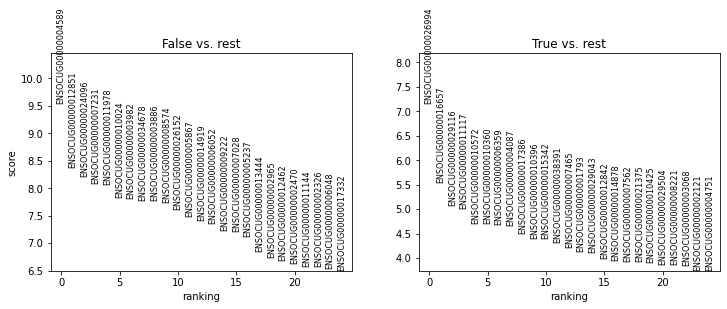

In [344]:
sc.pl.rank_genes_groups(start_adata, n_genes=25, sharey=False)


In [348]:
def getFateGenes(adata,fates_ds,start_day,target_celltype, target_time):
        start_fates = fates_ds[fates_ds.obs["day"]==start_day,]
        start_probs = pd.Series(start_fates[:,target_celltype].X.ravel())
        top_cells = start_fates.obs.index[start_probs > start_probs.quantile(0.9)]
        start_adata = adata[adata.obs["day"]==start_day ,]
        start_adata.obs["top_fated_cells"] = ["True" if x else "False" for x in start_adata.obs.index.isin(top_cells)]
        sc.tl.rank_genes_groups(start_adata, 'top_fated_cells', method='t-test')
        sc.pl.rank_genes_groups(start_adata, n_genes=25, sharey=False)


/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.
/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'barcode' as categorical
... storing 'stage' as categorical
... storing 'top_fated_cells' as categorical


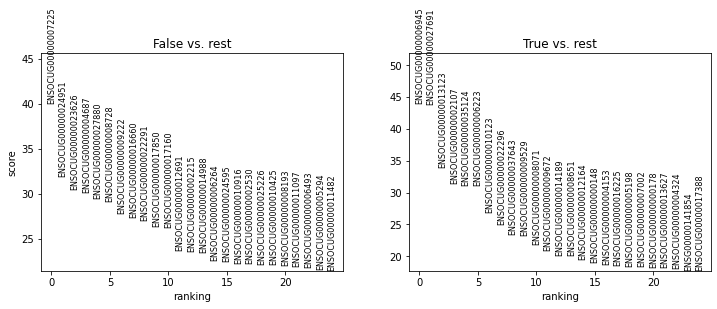

In [349]:
getFateGenes(rabbit_raw, rabbit_fates,8,"Gut",9)

/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.
/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'barcode' as categorical
... storing 'stage' as categorical
... storing 'theiler' as categorical
... storing 'cel

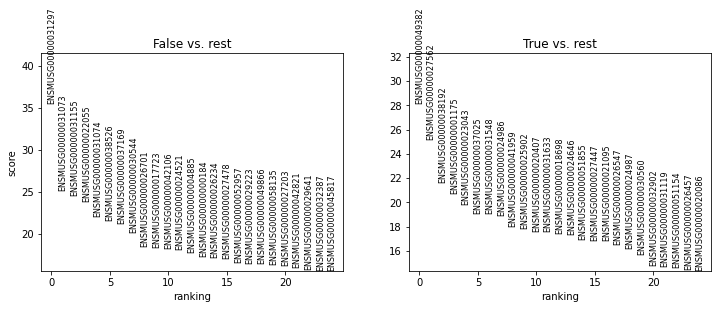

In [350]:
getFateGenes(mouse_raw, mouse_fates,7,"Gut",8.5)

In [385]:
sc.pp.neighbors(rabbit_corrected, n_pcs=0)


In [387]:
sc.tl.draw_graph(rabbit_corrected,layout="lgl")

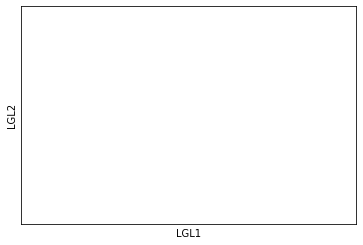

In [390]:
sc.pl.draw_graph(rabbit_corrected)

## PAGA

In [23]:
sc.tl.diffmap(rabbit)
sc.pp.neighbors(rabbit, n_neighbors=10)



TypeError: '>' not supported between instances of 'str' and 'int'

In [11]:
sc.tl.paga(rabbit, groups='cluster')


/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'barcode' as categorical
... storing 'stage' as categorical


/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


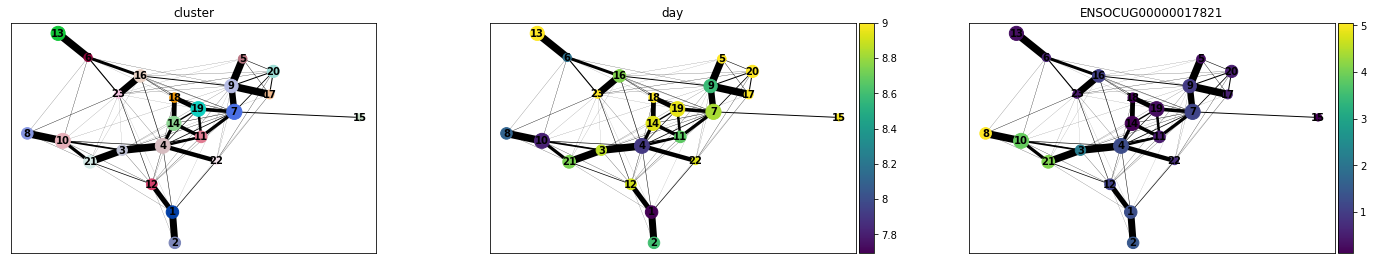

In [12]:
sc.pl.paga(rabbit, color=['cluster','day','ENSOCUG00000017821'])


In [ ]:
sc.tl.draw_graph(rabbit, init_pos='paga')


TypeError: '>' not supported between instances of 'str' and 'int'

In [15]:
sc.pl.paga_path(rabbit,[4,3,21,10,8],['ENSOCUG00000017821'])

ValueError: `pl.paga_path` requires computation of a pseudotime `tl.dpt` for ordering at single-cell resolution

In [ ]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain_anno']  == '16/Stem')[0]


In [ ]:
sc.tl.dpt(adata)


OverloadedDict, wrapping:
	{'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'n_neighbors': 10, 'method': 'umap', 'metric': 'euclidean'}, 'rp_forest': {'hyperplanes': {'start': array([     0,  17055,  34150,  51351,  68498,  85609, 102652, 119761,
       136726, 153783, 170826, 188123, 205198, 222117, 239246, 256463]), 'data': array([[ 11.232585  , -25.779114  , -10.164822  , ...,   0.09160662,
         -2.8714743 ,  -3.9813528 ],
       [ 26.7345    ,   0.09708595,   0.14065361, ...,  -1.961335  ,
          0.97070956,   1.2603937 ],
       [ 10.730518  ,   5.3490686 ,  -2.440796  , ...,   2.0136697 ,
         -0.19706658,   0.33517885],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.  

,cell,barcode,sample,stage,batch,doub.density,doublet,stripped,cluster,cluster.sub,cluster.stage,cluster.theiler,sizeFactor,day,covariate
cell_143439,cell_143439,AAAGGGCTCTGTCGCT,24,GD9,1,69.430796,False,False,9,4,3,NaN,0.878514,9,1
cell_122000,cell_122000,GGGAGATAGCCAGAGT,21,GD9,1,25.801639,False,False,14,7,14,NaN,0.677592,9,1
cell_105964,cell_105964,GAGTGTTGTTATCTGG,19,GD9,1,48.668571,False,False,20,8,4,NaN,0.455394,9,1
cell_27914,cell_27914,GCCATTCGTTCTCTAT,8,GD8,1,43.226575,False,False,4,6,5,NaN,0.737226,8,1
cell_137222,cell_137222,CTATCTAAGCAGTAAT,23,GD9,1,47.751111,False,False,20,9,4,NaN,0.536577,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_160186,cell_160186,CTACTATTCTACTGAG,25,GD9,1,10767.506173,False,False,7,1,11,NaN,1.180608,9,1
cell_120138,cell_120138,CCACCATAGAACTGAT,21,GD9,1,100.338430,False,False,7,3,11,NaN,2.032650,9,1
cell_57348,cell_57348,TCTGGCTCAATAACGA,11,GD8,1,140.853740,False,False,8,7,11,NaN,0.543176,8,1
cell_146806,cell_146806,CATCCCAGTTTGGCTA,24,GD9,1,177.239001,False,False,16,2,22,NaN,0.927042,9,1


In [448]:
rabbit_corrected.obs["celltype"] = "Unknown"

In [449]:
rabbit_corrected.obs["celltype"].replace(rabbit_gmt)

cell_143439    Unknown
cell_122000    Unknown
cell_105964    Unknown
cell_27914     Unknown
cell_137222    Unknown
                ...   
cell_160186    Unknown
cell_120138    Unknown
cell_57348     Unknown
cell_146806    Unknown
cell_156434    Unknown
Name: celltype, Length: 50000, dtype: object

In [450]:
dict2 = {v : k for k, v in rabbit_gmt.items()}

TypeError: unhashable type: 'list'

AttributeError: 'DataFrame' object has no attribute 'map'

In [ ]:
for k,v in rabbit_gmt.items():
    cells = [i.replace("'","") for i in v]
    rabbit_corrected[cells,:].obs["celltype"] = k

In [468]:
type(rabbit_gmt["Epiblast"])

list

In [ ]:
    rabbit_corrected[np.asarray(rabbit_gmt["Epiblast"]),:].obs["celltype"]

In [ ]:
for k,v in rabbit_gmt.items():
    rabbit_corrected[np.array(v),:].obs["celltype"]

# RANDOM


In [477]:
rabbit_raw.obsm["umap"] = rabbit_raw.obsm["UMAP"]

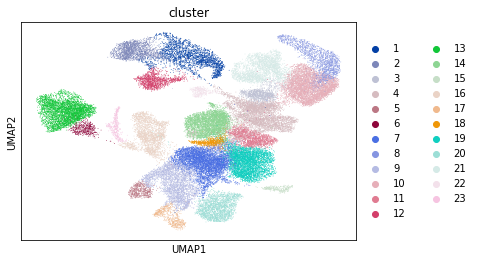

In [478]:
sc.pl.umap(rabbit_raw,color="cluster")

In [481]:
rabbit_subset = rabbit_raw[rabbit_raw.obs["cluster"].isin([14,18,4,11]),:]

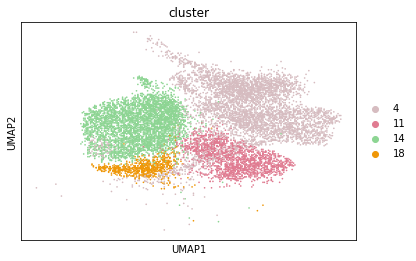

In [482]:
sc.pl.umap(rabbit_subset,color="cluster")

In [505]:
del rabbit_subset.obsm["X_umap"]

In [509]:
del rabbit_subset.obsm["umap"]

In [518]:
sc.pp.neighbors(rabbit_subset, n_neighbors=100, n_pcs=50)
sc.tl.umap(rabbit_subset,min_dist=0.9)


/nfs/research1/marioni/dkeitley/anaconda/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


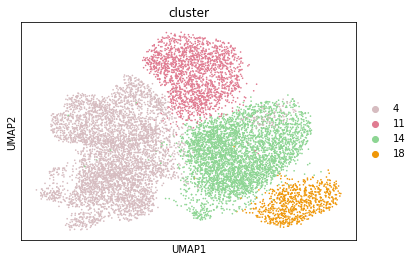

In [519]:
sc.pl.umap(rabbit_subset,color="cluster")

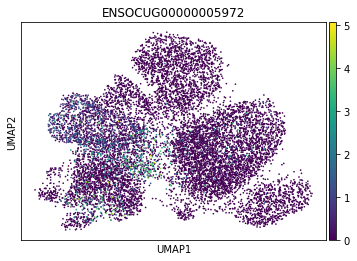

In [520]:
sc.pl.umap(rabbit_subset,color="ENSOCUG00000005972")

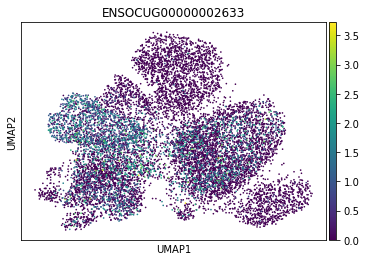

In [521]:
sc.pl.umap(rabbit_subset,color="ENSOCUG00000002633")